# Bayesian Inference with IBIS's MCMC Sampling

In order to better understand our model inputs, Atwood number and velocity, we're going to use Bayesian inference to combine our model data and prior knowledge with observed, experimental data. In this case the posterior distribution that we're after is the distribution of values of mixing width at a certain time, and that distribution has been informed by both the physics model and observed data. Since it can be complicated to compute the posterior distribution we will use IBIS's MCMC sampling module to approximate it. 

## Connect to the Kosh store to access datasets

Again, we can connect to our Kosh store and ensemble to conveniently have access to all the data we need. We're going to need both the simulation data and experimental data for MCMC sampling.

In [2]:
import numpy as np
import kosh
import scipy.stats as sts
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from ibis import mcmc
import os


# Connect to the Kosh store and read in datasets
store_dir = os.path.join(os.getcwd(), "RT_UQ/pyranda.sql")
store = kosh.connect(store_dir)
print(store)

# The experimental data was saved to the ensemble in our Kosh store
experiments_ensemble = next(store.find_ensembles(name="experiments"))
exp_uri = next(experiments_ensemble.find(mime_type="pandas/csv")).uri

# The simulation data was just generated with the workflow manager (Maestro or Merlin)
# and ingested by the Sina database
name = "RT_UQ"
sim_ensemble = next(store.find_ensembles(name=name))
sim_uri = next(sim_ensemble.find(mime_type="pandas/csv")).uri

# Use the URI to read in datasets
rt_exp_data = np.genfromtxt(exp_uri, delimiter=',')
rt_sim_data = np.genfromtxt(sim_uri, delimiter=',')

print(f"Experimental data size: {rt_exp_data.shape}")
print(f"Simulation data size: {rt_sim_data.shape}")

# Separate inputs and outputs for experimental and simulation data
xexp = rt_exp_data[:, :2]
yexp = rt_exp_data[:, -1]   # The last element is for time 60.0 sec.
xsim = rt_sim_data[:, :2]
ysim = rt_sim_data[:, 2:]

Experimental data size: (20, 13)
Simulation data size: (100, 3)


## Train the Surrogate Model

Let's train our Gaussian process model on the simulation data. We want this surrogate model to be able to emulate the real simulation, but provide predictions much faster. 

In [12]:
# The GP model and MCMC sampling perform better when inputs are scaled
# Using a min-max scaler from scikit-learn
scaler = MMS()
scaled_xsim = scaler.fit_transform(xsim)

# Also scale experimental data in the same way
scaled_xexp = scaler.transform(xexp)

# Build the GP surrogate for time 60.0 sec
kernel = 1.95 * RBF(1.0, length_scale_bounds="fixed")
surrogate = GPR(kernel=kernel, normalize_y=False)
surrogate.fit(scaled_xsim, ysim)

print(f"Surrogate model {surrogate}")

Surrogate model GaussianProcessRegressor(kernel=1.4**2 * RBF(length_scale=1))


## Defining variables for MCMC sampling

We need to provide a lot of information for the MCMC sampling function. We'll start by defining information for the inputs.

In [4]:
# Start by instantiating the mcmc object
default_mcmc = mcmc.DefaultMCMC()

# Input information
input_names = ['atwood_num', 'vel_mag']

# Calculate standard deviation for simulation input features
sim_std = np.std(scaled_samples, axis=1)

# We define the min and max for each input
ranges = [[.3, .8], [.7, 1.3]]

# Add inputs
# We're using uninformative priors for both inputs
for i, name in enumerate(input_names):
    default_mcmc.add_input(name, 0.0, 1.0, sim_std[i], sts.uniform().pdf,
                            unscaled_low=ranges[i][0], unscaled_high=ranges[i][1], scaling='lin')

print(f"Inputs: {default_mcmc.inputs}")

Inputs: {'atwood_num': <ibis.mcmc.InputVariable object at 0x7ffe92b1ae80>, 'vel_mag': <ibis.mcmc.InputVariable object at 0x7fffd45c9cd0>}


Next we define information for the outputs.

In [13]:
# Output information
output_name = 'mix_width-60s'

# Create names for experimental data
expNames = [f"exp{i}" for i in range(len(yexp))]

# Find standard deviation estimate
exp_std = yexp.std()
print(f"Output std estimate: {exp_std}")

# Add outputs
for i, expName in enumerate(expNames):
        default_mcmc.add_output(expName, output_name, surrogate, yexp[i], exp_std, input_names)
    
print(f"Outputs: {default_mcmc.outputs}")

Output std estimate: 0.5470997996484055
Outputs: {'exp0_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b070>, 'exp1_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7ffe92c724c0>, 'exp2_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7ffe92b7a070>, 'exp3_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b340>, 'exp4_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7ba30>, 'exp5_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7beb0>, 'exp6_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7ba00>, 'exp7_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b790>, 'exp8_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b430>, 'exp9_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b2e0>, 'exp10_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbcc7b190>, 'exp11_mix_width-60s': <ibis.mcmc.OutputVariable object at 0x7fffbccdf220>, 'exp12_mix_width-60s': <ibis.mcmc.OutputVariable

## Run MCMC Sampling

We will define the rest of the information and run the chains for sampling the posterior distribution.

total: We are going to run chains of "total" in length. That's the total number of samples, but we will need to check the trace plot to see how the sampling looks. 

Start: Start means a starting value for each input. Here we are starting with .5 for both Atwood number and velocity. These are not likely to be the values that product the highest probability for the posterior distribution. So the sampling may explore different local maximums until it finds the global maximum. 

burn: We will want to only keep the samples that are exploring around the global maximum. The inital samples may wander, and we will drop them from the samples we keep. This is called the "burn-in" period. In this case we will drop the first 500 samples.

every: There is some correlation between the samples in the chain. The closer the samples are together, the more correlated they are. If we keep every 2 samples in this case, it reduces the correlation between our samples.

n_chains: We can run multiple independent sampling chains in parallel.

prior_only: Whether to run the chains on just the prior distributions.

seed: The random seed for the Metropolis-Hastings algorithm that chooses the next sample for the chain.

In [14]:
# Run the MCMC chains to get samples approximating the posterior distribution
default_mcmc.run_chain(total=5000,
                       burn=200,
                       every=2,
                       start={name: .5 for name in input_names},
                       n_chains=3,
                       prior_only=False,
                       seed=15)

chains = default_mcmc.get_chains(flattened=False, scaled=True)

Burning
Burning
Burning
Sampling Start
Sampling StartSampling Start

Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 40%
Sampling: 40%
Sampling: 40%
Sampling: 50%
Sampling: 50%
Sampling: 50%
Sampling: 60%
Sampling: 60%
Sampling: 60%
Sampling: 70%
Sampling: 70%
Sampling: 70%
Sampling: 80%
Sampling: 80%
Sampling: 80%
Sampling: 90%
Sampling: 90%
Sampling: 100%
Sampling Done
Sampling: 100%
Sampling Done
Sampling: 90%
Sampling: 100%
Sampling Done
    run_chain: 53.955379 s


## MCMC Sampling Plots

We'll start by looking at the trace plots. We want to see a good sampling of the space, and since we already removed the "burn-in" samples the center of the mixing should stay in one place.

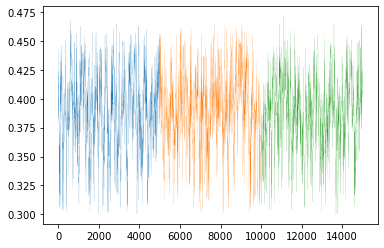

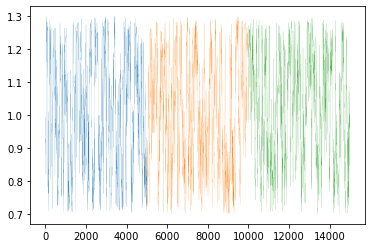

In [15]:
for input_n in input_names:
    default_mcmc.trace_plot(input_name=input_n)

Next we will view the histogram showing us a rough approximation of the posterior distribution for the mixing width. 

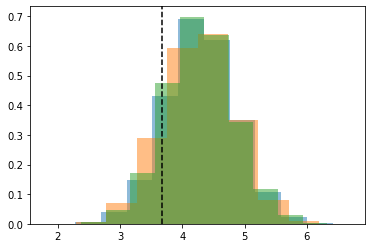

In [16]:
outvar = list(default_mcmc.outputs.keys())[0]
post_pp = default_mcmc.posterior_predictive_plot(outvar, bins=10)

Now we can see the more informed distributions for our uncertain parameters.

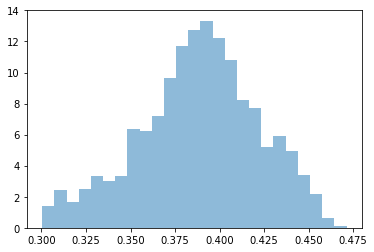

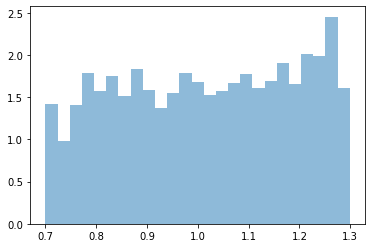

In [17]:
for input_n in input_names:
    hist_plot = default_mcmc.histogram_plot(input_name=input_n, bins=25, density=True, alpha=.5)

In the future we could use these distributions for Atwood number and density to make better predictions with error estimates.